In [1]:
# %reset
import pandas as pd
from pandas import read_excel
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter

# Regression
from sklearn.linear_model import LogisticRegression

# Optimal Transport
import ot

# For Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Hyperparameters

In [2]:
d = 1 # Problem Dimension (<- we can likely remove this)
k = 5  # number of Diracs of the barycenter
N_clusters = 5 # Number of clusters
train_percentage = .9 # Relative Proportion of Train to Test Set Size (I make it small for debugging)
Window_Length = 3 # This is the memory held by the logistic regression

---

In [3]:
filepath = './lob_bid_shape.xlsx'
bid_data = pd.read_excel(filepath,header=None)
bid_data_np = bid_data.to_numpy(copy=True)
bid_data_new = bid_data_np[:,1:]

LL = len(bid_data_new)
train_len = np.int(np.floor(train_percentage*LL))
test_len  = LL-train_len
print("Training Size: "+str(train_len))
print("Testing Size: "+str(test_len))

## Initialize Training Set
bid_data_new_train = bid_data_new[0:train_len,]

FileNotFoundError: [Errno 2] No such file or directory: './lob_bid_shape.xlsx'

## Perform Clustering

In [4]:
kmeans = KMeans(n_clusters=N_clusters, random_state=0).fit(bid_data_new)

datalabels = kmeans.labels_
print(sorted(Counter(datalabels).items()))

[(0, 1127), (1, 814), (2, 2892), (3, 2157), (4, 667)]


## Get Average LOB Shapes:
Via: Wasserstein Barycenters from Each Cluster

In [5]:
# Initializations
LOB_Shapes = []

# Build List of LOB shapes by looping over all clusters
for current_cluster in range(N_clusters):

    # Extract Data from Current Cluster
    idx = np.where(datalabels==current_cluster)
    cluster_50 = np.squeeze(bid_data_new[idx,])


    # (Internal) Initializations
    ## Cluster Size
    TT = len(cluster_50)
    ## Initialize List
    measures_locations_list = []
    measures_weights_list = []
    ## Initialize Internal Location/Loop
    measures_locations_loop = np.zeros(5)
    measures_weights_loop   = np.zeros(5)
    # Mean Weights of the Shape
    measures_weights_mean   = np.zeros(5)

    for i in range(TT):
        # Get LOB Shape
        measures_locations_loop[0] = cluster_50[i,0]
        measures_locations_loop[1] = cluster_50[i,2]
        measures_locations_loop[2] = cluster_50[i,4]
        measures_locations_loop[3] = cluster_50[i,6]
        measures_locations_loop[4] = cluster_50[i,8]
        measures_weights_loop[0]   = cluster_50[i,1] 
        measures_weights_loop[1]   = cluster_50[i,3] 
        measures_weights_loop[2]   = cluster_50[i,5] 
        measures_weights_loop[3]   = cluster_50[i,7] 
        measures_weights_loop[4]   = cluster_50[i,9] 

        # Append to List
        measures_weights_list.append(measures_weights_loop)
        measures_locations_list.append(measures_locations_loop.reshape(5,1))

        # Update Mean
        measures_weights_mean += measures_weights_loop


    # Get Barycenter
    ## Get Barycenter Weights
    measures_weights_mean = measures_weights_mean/TT # Normalize Shape
    ## Get Barycenter Prices
    X_init = np.random.normal(0., 1., (k, 1))  # initial Dirac locations
    b = np.ones((k,)) / k  # weights of the barycenter (it will not be optimized, only the locations are optimized)
    X = ot.lp.free_support_barycenter(measures_locations_list, measures_weights_list, X_init, b) # Get Wasserstein Locations
    ## Set LOB shape of this barycenter
    LOB_shape = pd.DataFrame({'prices':np.round(X.reshape(k,),3),'weights':measures_weights_mean}) # Set LOB Shape

    # Join LOB shape of this barycenter to list of shapes
    LOB_Shapes.append(LOB_shape)

## Get Dissimilarity Matrix:
$$
D_{i,j} = W_2\left(
\hat{\mathbb{S}}_i,\hat{\mathbb{S}}_j
\right),
$$
where $\hat{\mathbb{S}}_i$ is the $i^{th}$ average LOB shape obtained in the last step.  

In [6]:
# Initialize Dissimilarity Matrix
Dissimilarity_matrix_ot = np.zeros([N_clusters,N_clusters])
# Populate Dissimilarity Matrix
for i in range(N_clusters):
    for j in range(N_clusters):
        Dissimilarity_matrix_ot[i,j] = ot.wasserstein_1d(np.array(LOB_Shapes[i]['weights']),
                                                         np.array(LOB_Shapes[j]['weights']),
                                                         np.array(LOB_Shapes[i]['prices']),
                                                         np.array(LOB_Shapes[j]['prices']))
# Format Dissimilarity Matrix (as DataFrame)
Dissimilarity_matrix_ot = pd.DataFrame(Dissimilarity_matrix_ot)
# View Dissimilarity Matrix
pd.DataFrame(Dissimilarity_matrix_ot)

,0,1,2,3,4
0,0.000000,1.317477,0.947717,0.765728,1.597348
1,1.318987,0.000000,1.622340,1.570497,1.548366
2,0.947102,1.618158,0.000000,0.215919,1.979653
3,0.766386,1.569230,0.216074,0.000000,1.971700
4,1.597217,1.547485,1.981103,1.969584,0.000000


# Visualization of LOB Shape

Plot two most dissimilar LOB Shapes

In [7]:
# Identify Most Different LOB Shapes
Max_Dissimilarity = np.unravel_index(np.argmax(Dissimilarity_matrix_ot, axis=None), Dissimilarity_matrix_ot.shape)
print(Max_Dissimilarity)

(4, 2)


AxesSubplot(0.125,0.125;0.775x0.755)


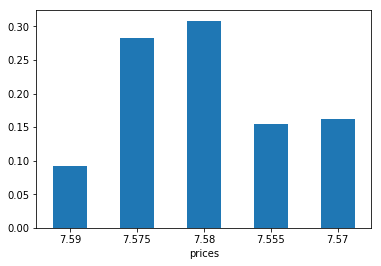

In [8]:
print(LOB_Shapes[Max_Dissimilarity[0]].set_index('prices')['weights'].plot.bar(rot=0))

AxesSubplot(0.125,0.125;0.775x0.755)
Most Dissimilar LOB Shape to: 2 is: 4


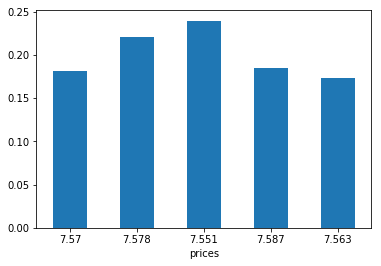

In [9]:
print(LOB_Shapes[Max_Dissimilarity[1]].set_index('prices')['weights'].plot.bar(rot=0))
print("Most Dissimilar LOB Shape to: " +str(Max_Dissimilarity[1])+" is: "+str(Max_Dissimilarity[0]))

Plot Most similar LOB Shape to the above

AxesSubplot(0.125,0.125;0.775x0.755)
Most Similar LOB Shape to: 2 is: 3


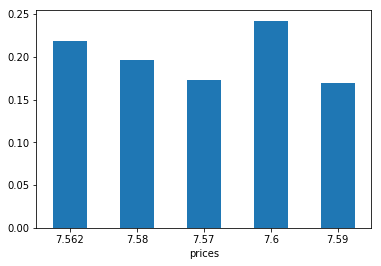

In [10]:
index_of_most_similar = np.argmax(np.sort(np.array(Dissimilarity_matrix_ot[Max_Dissimilarity[1]]))[1]==np.array(Dissimilarity_matrix_ot[Max_Dissimilarity[1]]))
print(LOB_Shapes[index_of_most_similar].set_index('prices')['weights'].plot.bar(rot=0))
print("Most Similar LOB Shape to: " +str(Max_Dissimilarity[1])+" is: "+str(index_of_most_similar))

## Build Classes For Logit

Note: We also report the mean dimension reduction error, defined by:
$$
\sum_{S_t \in \mbox{train}} \min_{k\leq K} W_2^2\left(
S_t,
S^{\star:k}
\right),
$$
where $K$ is the number of main LOB shapes $\{S^{\star:k}\}_{k\leq K}$.

As we expect, this number decreases as the number of main LOB shapes increase (sanity check).  

In [11]:
# Initialize Training Labels
bid_data_new_train_main_LOB_Shape_Labels = np.zeros([train_len-1])

# Initialize dimension reduction error
mean_dim_redux_error = 0

# Populate Matrix of Labels
for i in range(train_len-1):
    # Initialize Classes
    current_LOB_shape_loop = bid_data_new_train[i,]

    # Extract Current LOB Data
    ## Get Locations
    current_LOB_Shape_locations = np.array([current_LOB_shape_loop[0],
                                            current_LOB_shape_loop[2],
                                            current_LOB_shape_loop[4],
                                            current_LOB_shape_loop[6],
                                            current_LOB_shape_loop[8]])
    ## Get Weights
    current_LOB_Shape_weights = np.array([current_LOB_shape_loop[1],
                                          current_LOB_shape_loop[3],
                                          current_LOB_shape_loop[5],
                                          current_LOB_shape_loop[7],
                                          current_LOB_shape_loop[9]])


    # Compute Wasserstein Distance with each main LOB shape
    ## Initialize Dissimilarity Matrix
    Similarity_vector_ot = np.zeros(N_clusters)
    for j in range(N_clusters):
        Similarity_vector_ot[j] = ot.wasserstein_1d(current_LOB_Shape_weights,
                                                    np.array(LOB_Shapes[j]['weights']),
                                                    current_LOB_Shape_locations,
                                                    np.array(LOB_Shapes[j]['prices']))
    ## Identify which is minimum amongst clusters
    main_LOB_shape_assosiated_to_current = np.argmin(Similarity_vector_ot)
    ## Update Labels Matrix
    bid_data_new_train_main_LOB_Shape_Labels[i] = main_LOB_shape_assosiated_to_current
    
    # Mean Error
    mean_dim_redux_error += np.min(Similarity_vector_ot)
    
# Report Mean Dimension Reduction Error
mean_dim_redux_error = mean_dim_redux_error/train_len
print("The Average Error Incured by the Low-Dimensional Representation is: "+str(mean_dim_redux_error))

The Average Error Incured by the Low-Dimensional Representation is: 0.5327454429817894


## Perform Classification
The goal is to predict the next main_LOB_shape using a window of historical data.
In this iteration, we use Logistic Regression

---
*Note:* Erdinç, in this iteration I only used a window of length 1, but please could you make this length euql to the hyperparameter : *"Window_Length"*?

In [12]:
# Initialize Logistic Regressor
logistic_regressor = LogisticRegression(random_state=2020)
# Train Logistic Regressor
logistic_regressor.fit(bid_data_new_train[1:],bid_data_new_train_main_LOB_Shape_Labels)

# Test-Set Predictions

/scratch/users/kratsioa/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2020, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Visualization: LOB Shape Evolution (in-sample)

Correct LOB Shape Is predicted 0.5397677793904209% of the time.
Classifier is Beating Random Guessing by: 0.33976777939042085%


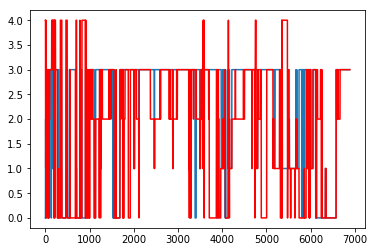

In [14]:
plt.plot(logistic_regressor.predict(bid_data_new_train[1:]))
plt.plot(bid_data_new_train_main_LOB_Shape_Labels,color='red')

# Report Accuracy
accuracy = np.mean(np.abs(bid_data_new_train_main_LOB_Shape_Labels==logistic_regressor.predict(bid_data_new_train[1:])))
print("Correct LOB Shape Is predicted " + str(accuracy) + "% of the time.")
if accuracy>(1/N_clusters):
    print("Classifier is Beating Random Guessing by: "+str(accuracy-(1/N_clusters)) +"%!")
else:
    print("Classifier is loosing against Random Guessing: "+str((1/N_clusters)-accuracy) +"%!")

---